In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from itertools import compress
import re
import csv

# Load Data

In [2]:
data = pd.read_pickle("../data/data_medium.pkl")

In [3]:
data["sender"] = [str(s.user_id)  if s else "NaN" for s in data["sender"]]
data["reply_to"] = [float(r) for r in data["reply_to"]]
data["reply_to"] = [str(int(r)) if r.is_integer() else "NaN" for r in data["reply_to"]]
data["message_id"] = [str(i) for i in data["message_id"]]
data["contains_link"] = [m and "http" in m for m in data["message"]]
data["contains_link"] = data["contains_link"].replace("", False)
data["contains_link"] = data["contains_link"].fillna(False)

# Metrics for datasets

## Functions for different metrics

In [4]:
def calc_link_ratio(contains_link):
    """What proportion of messages contains links?"""
    return sum(contains_link)/len(contains_link)

def find_top_links(msgs, contains_link):
    """Returns ranked list of all sent links and their count."""
    msgs = list(compress(msgs, contains_link))
    regex = r"https?://((www|m)\.)?([^\s/]+\.\w{2,8})/"
    links = []
    for msg in msgs:
        find = re.findall(regex, msg)
        for f in find:
            links.append(f[2])
    links = Counter(links)
    links = [(l, c) for l,c in links.items()]
    links.sort(key=lambda x: x[1], reverse=True)
    return links 

In [5]:
def calc_sender_stats(senders):
    """Returns dictionary containing metrics regarding senders."""
    info = {}
    count = Counter(senders)
    info["total_senders"] = len(count)
    
    vals = sorted(count.values())
    info["counts"] = vals
    info["mean"] = sum(vals)/len(vals)
    if len(vals)%2 != 0:
        info["median"] = vals[len(vals)//2]
    else:
        f = len(vals)//2
        info["median"] = (vals[f] + vals[f+1])/2
    return info

In [6]:
def calc_speed(time):
    """Returns msgs/hour."""
    time = list(time)
    hours = (time[0] - time[-1]).total_seconds()/60/60
    speed = len(time)/hours
    return speed

def get_lofi_times(times, resolution=1., start=None):
    """Reformat times so it can be plottet in a more comprehensible way.
    resoltion sets the number of hours that should be grouped together, preferrably should be n where 24%n == 0."""
    lofi_times = []
    for t in times:
        if start and t < start:
            continue
        h = (t.hour//resolution) * resolution
        lofi_t = t.replace(minute=0, second=0, hour=h)
        lofi_times.append(lofi_t)
    return lofi_times

In [7]:
def calc_answer_ratio(reply_to):
    """Return answers/msgs"""
    not_answers = reply_to.count("NaN")
    answer_ration = 1-(not_answers/len(reply_to))
    return anwer_ratio

## Inspect Data

In [8]:
groups = data.index.get_level_values(0).unique().tolist()

### Show top posted links

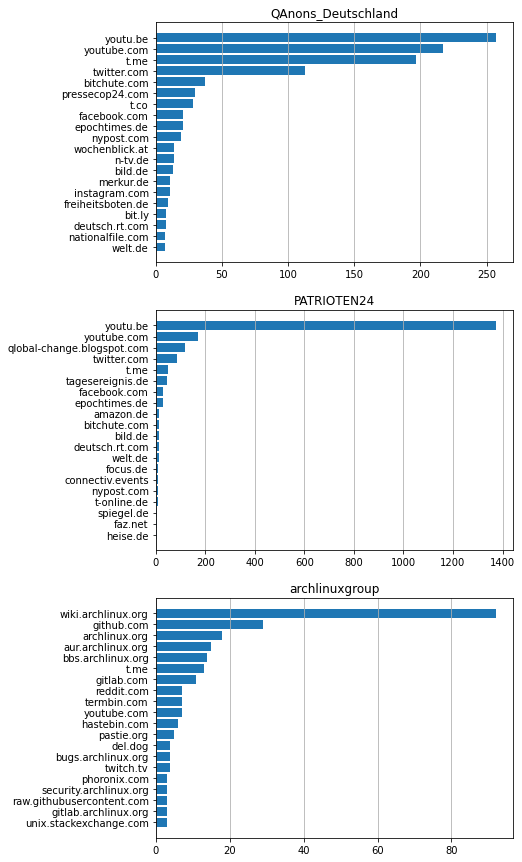

In [9]:
fig, axes = plt.subplots(len(groups), figsize=(6.4, len(groups)*5))

for group, ax in zip(groups, axes):
    this_data=data.xs(group)
    top_links = find_top_links(this_data["message"], this_data["contains_link"])
    n = 20
    labels, vals = zip(*top_links[:n])
    labels = list(reversed(labels))
    vals = list(reversed(vals))
    x = [i for i in range(n)]
    ax.barh(x, vals, tick_label=labels)
    ax.set_title(group)
    ax.grid(axis="x")
    
fig.savefig("../figures/top_links.pdf", bbox_inches="tight", dpi=150)

### Inspect Senders

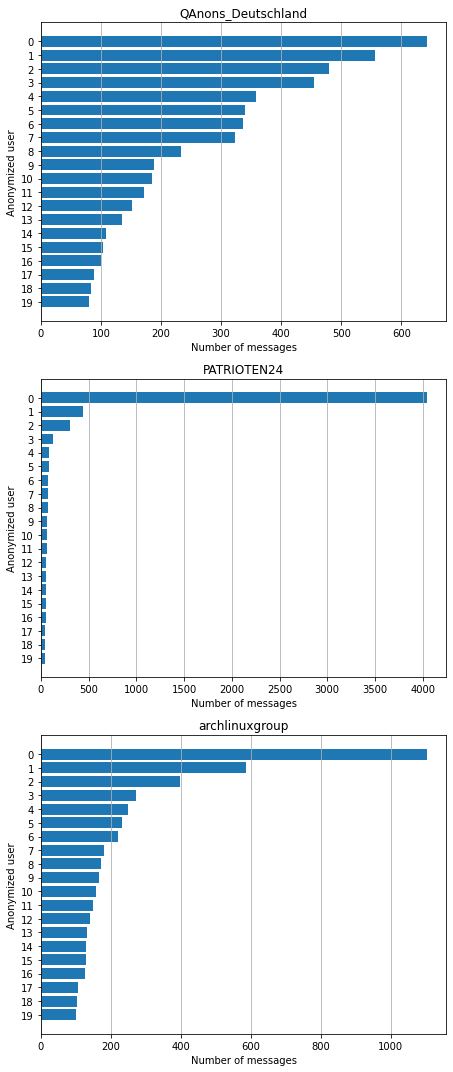

In [10]:
fig, axes = plt.subplots(len(groups), figsize=(6.4, len(groups)*5))

for group, ax in zip(groups, axes):
    this_data=data.xs(group)
    sender_stats = calc_sender_stats(this_data["sender"])
    n = 20
    x = [i for i in range(n)]
    counts = sender_stats["counts"]
    
    # horizonal barplot shows how many messages were sent by specific users
    ax.barh(x, counts[-n:], tick_label=list(reversed(x)), color="C0")
    ax.set_ylabel("Anonymized user")
    ax.set_xlabel("Number of messages")
    ax.set_title(group)
    ax.grid(axis="x")

    

fig.tight_layout()
fig.savefig("../figures/senders.pdf", dpi=150)

### Messages over time

In [11]:
start = pd.Timestamp(year=2020, month= 10, day=17, hour = 12, tz="UTC")
lofi_times = {g: get_lofi_times(data.xs(g)["time"], resolution=1, start=start) for g in groups}

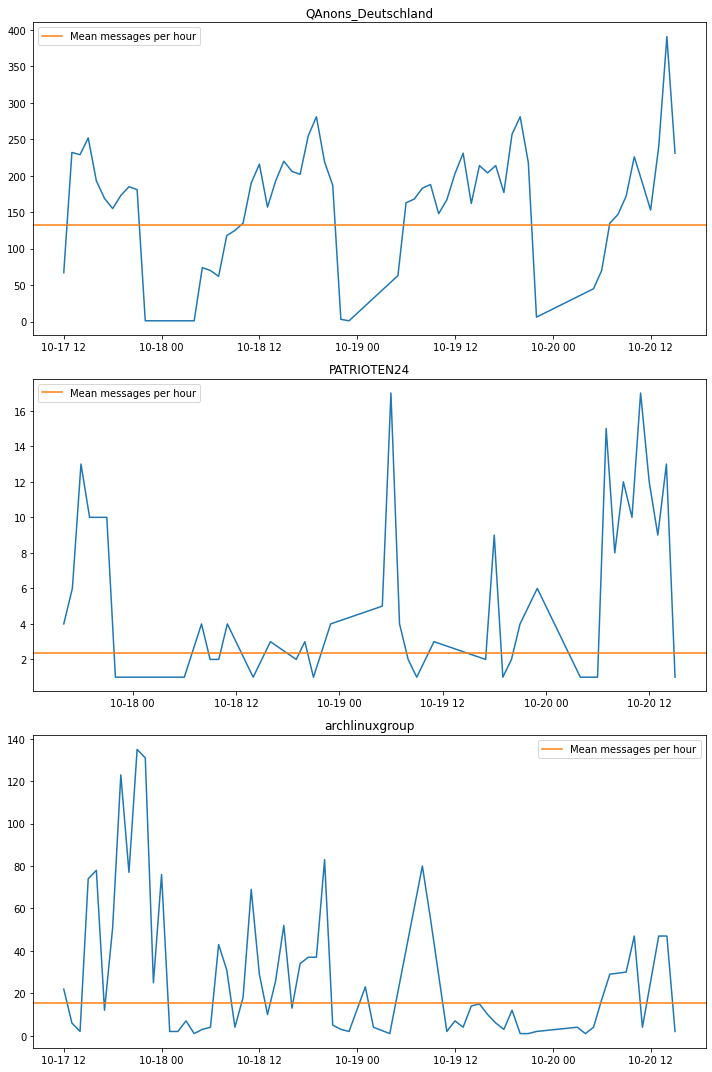

In [12]:
fig, axes = plt.subplots(len(groups), figsize=(10, len(groups)*5))

for group, ax in zip(groups, axes):
    times, counts = zip(*Counter(lofi_times[group]).items())
    ax.plot_date(times, counts, "b-", xdate=True, c="C0")
    ax.set_title(group)
    ax.axhline(calc_speed(data.xs(group)["time"]),c="C1", label="Mean messages per hour")
    ax.legend()

fig.tight_layout()
fig.savefig("../figures/time.pdf", dpi=150)